# Pre Processing: Feature Selection

Feature Selection is an important step in data pre-processing. It consists in selecting the best subset of input variable as the most pertinent. 


### Import Libraries

In [1]:
from tokenize import String
from plotly.subplots import make_subplots
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import scipy.stats as stats
import geopandas as gpd
import numpy as np
from numpy import arange
from fs import methods as m
from fs import model as ml
import ipywidgets as widgets
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, clear_output
from sklearn import preprocessing
import os
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import AppLayout, Layout

pd.set_option('display.max_rows', 500)


### Dataframe 
Different configurations are set in order to 

In [2]:

geopackages = ['0324_0331_2021','0418_0425_2021', '0717_0724_2021','0903_0910_2021','1007_1014_2021']
params = ['0_1_mountains', '0_1_nomountains', '0_01_mountains', '0_01_nomountains']

var_t = 'empty'
target_labels = []
dictionary_results = {}
params = ['0_1_mountains', '0_1_nomountains', '0_01_mountains', '0_01_nomountains']
dataframes_results = {}



## Results Feature Selection
In this section fs results are evaluated for each geopackages contained in the folder [grids/](https://github.com/opengeolab/D-DUST/tree/thesis_MB/notebooks/grids).<br />
The results are stored in a list of dataframe (one for each dataset) and are displayed in n bar plot. <br />
Each subplot refers to the method choosen with the dropdown widgets, with the possiblity to normalized results or not. <br />
The methods used are:

* Pearson correlation;
* Spearmanr correlation;
* Kendall tau; 
* F-Test;
* Random Forest importance; 

<br />
In addition, an average score for these methods is added.



In [3]:
labels = list(gpd.read_file('assets/grids_0_1/grid_0_1_'+ geopackages[0]+'.gpkg').dropna(axis=0).dropna(axis=1).columns)
method_list = ['Pearson', 'Spearmanr', 'Kendall', 'Fisher', 'RF Importance', 'RFS']
resolutions = []
for l in labels:
    if(l.endswith('_st')):
        target_labels.append(l)

results_norm = widgets.Checkbox(
    value=True,
    description='Results normalized',
    disabled=False,
    indent=True
)

#Radiobutton used to display data in regular or logaritmic scale
scale = widgets.RadioButtons(
    options=['Regular', 'Logaritmic'],
    description='Scale:',
    disabled=False
)

compute_button = widgets.Button(
    description='Compute',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    #tooltip='Compute',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout = Layout(width='60%', margin='10px 150px 10px 80px')


)

#Radiobutton used to display data ordered by score or by labels
order = widgets.RadioButtons(
    options=['Labels', 'Scores'],
    description='Order by:',
    disabled=False
)
params_choosen = widgets.Dropdown(
    options= ['10km', '10km without mountains', '1km', '1km without mountains'],
    value = '10km',
    description='Parameter:',
    disabled=False,
    layout = Layout(width='95%')
)

#Dropdown widgets used to choose the scores of the method selected
method_choosen = widgets.Dropdown(
    options=['---']+ method_list + ['Borda Count Voting'],
    value='---',
    description='Method:',
    disabled=False,
    layout = Layout(width='90%')
)


target_variable = widgets.Dropdown(
    options=target_labels,
    value=target_labels[0],
    description='Target:',
    layout = Layout(width='90%')
)

variance_TH= widgets.Checkbox(
    value=True,
    description='Apply',
    disabled=False,
    indent=False,
    layout = Layout(margin='10px 10px 10px 80px')

)

value_th = widgets.Dropdown(
    options=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    value=0,
    description='Variance TH:',
    disabled=False,
    layout = Layout(width='90%')

)

labels_list = []

def compute_button_f(b):
    clear_output()
    global features_deleted
    global th
    global var_t
    global labels
    global dataframes_results
    global target_var
    labels_list.clear()


    var_t = target_variable.value
    for par in params:
        dataframes_results.clear()

        for index, grid in enumerate(geopackages):
            #read gpkg file
            if(par[0:3] == '0_1'):
                data = gpd.read_file('assets/grids_0_1/grid_0_1_'+ grid+'.gpkg')
                data = m.process_data(data, 10, target_variable.value)
            else:
                data = gpd.read_file('assets/grids_0_01/grid_0_01_'+ grid+'.gpkg')
                data = m.process_data(data, 30, target_variable.value)

            if(par[-11:]=='nomountains'):
                data = data[data['clim_zone'] > 3]
            data.pop('clim_zone')

            data = data[~data[target_variable.value].isnull()]
            data = data.dropna(axis=1).dropna(axis=0)
            data.pop('geometry')
            labels = list(data.columns)

            #read variables which are not null
            score_results = pd.DataFrame()

            #Store dataset in x and y variables
            X = pd.DataFrame(data=data, columns=labels )
            Y = X[target_variable.value]
            Y = Y.values.ravel()
            X.pop(target_variable.value)
            X.pop('lat_cen')
            X.pop('lng_cen')

            if value_th.disabled == False:
                scores_th = m.variance_threshold(X, value_th.value)

                for i, label in enumerate(scores_th['Features']):
                    if scores_th['Scores'].tolist()[i] != 1:
                        X = X.drop(label, 1)


            X = X.apply(stats.zscore)
            X = X.dropna(axis=1)
            Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)

            labels = X.columns.tolist()
            labels_list.append(labels)
            score_results['Features'] = labels

            score_results = m.fs_results_computation(X, Y)

            s = score_results.copy()
            s['Pearson'] = s['Pearson'].abs()
            s['Kendall'] = s['Kendall'].abs()
            s['Spearmanr'] = s['Spearmanr'].abs()


            var_t = target_variable.value
            score_results['Borda Count Voting'] = m.borda_voting(s)
            score_results.to_excel('assets/fs_results/'+par+grid+'out.xls')
            score_results.to_csv('assets/fs_results/'+par+grid+'out.csv')


            dataframes_results[grid] = score_results.copy()
            
        method_choosen.value = '---'
        dictionary_results[par] = dataframes_results.copy()


        target_var= target_variable.value



def fs_manager(change_scale, method, normalized_results, target, order, filter_variance, th_value, param):

    if filter_variance == True:
        value_th.disabled = False
    else :
        value_th.disabled = True

    if method == '---':
        return

    df = []

    if(param == '10km'):
        df = dictionary_results['0_1_mountains']
    if(param == '10km without mountains'):
        df = dictionary_results['0_1_nomountains']
    if(param == '1km'):
        df = dictionary_results['0_01_mountains']
    if(param == '1km without mountains'):
        df = dictionary_results['0_01_nomountains']
    res = []
    labels_list = []

    if(normalized_results):
        for grid in geopackages:
            temp = (df[grid])[method]
            temp = m.NormalizeData1D(temp)
            res.append(temp)
            labels_list.append(df[grid]['Features'].tolist())
    else:
        for grid in geopackages:
            temp = (df[grid])[method]
            labels_list.append(df[grid]['Features'].tolist())
            res.append(temp)


    if (change_scale == 'Logaritmic'):
        m.show_bars_log(labels_list, res, method, geopackages, order)
        return

    else:
        m.show_bars(labels_list, res, method, geopackages, order)

title= widgets.HTML('<h2 style="text-align:center;">Options</h2><hr><h3 style="padding: 10px;">Input</h3>')
features_deleted = widgets.HTML('')
title2 = widgets.HTML('<h2 style="text-align:center;">Feature Selection scores</h2><hr>')
plots = widgets.interactive_output(fs_manager, {'method':method_choosen, 'change_scale': scale, 'order':order, 'normalized_results': results_norm, 'target': target_variable, 'filter_variance':variance_TH,'th_value':value_th,  'param':params_choosen})
plot = widgets.VBox([title2, plots], layout=Layout(border='solid'))
output = widgets.VBox([title, target_variable, value_th, variance_TH, compute_button,widgets.HTML('<br><h3 style="padding: 10px;">Output</h3'),params_choosen,
                           method_choosen, scale, order, results_norm], layout=Layout(border='solid'))

ui = AppLayout(header=None,
          left_sidebar=output,
          center=plot,
          right_sidebar=None,
          footer=None,
              layout=Layout(border='solid'))

compute_button.on_click(compute_button_f)

container = widgets.Box([ui], )
display(container)


Box(children=(AppLayout(children=(VBox(children=(HTML(value='<h2 style="text-align:center;">Options</h2><hr><h…

### Export Feature Selection
By running this section, a dataframe containing the list of feature selected ordered by its average score value is exported as .csv file.

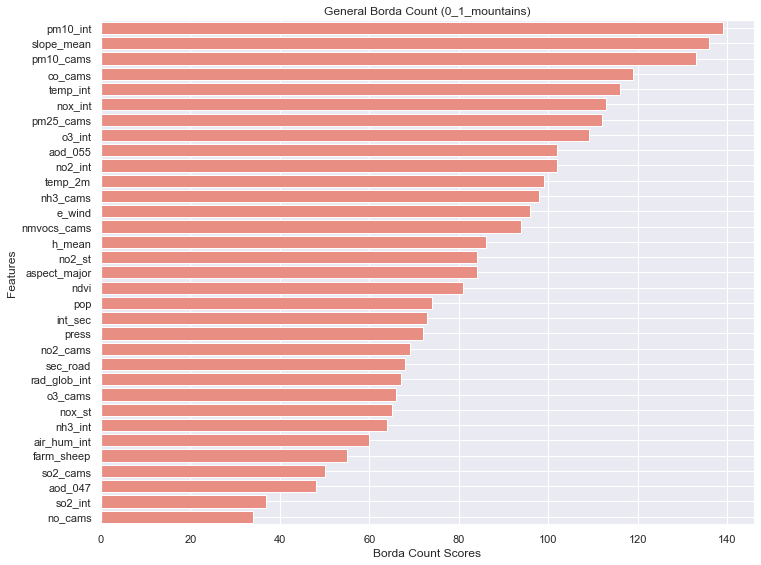

<Figure size 842.4x667.44 with 0 Axes>

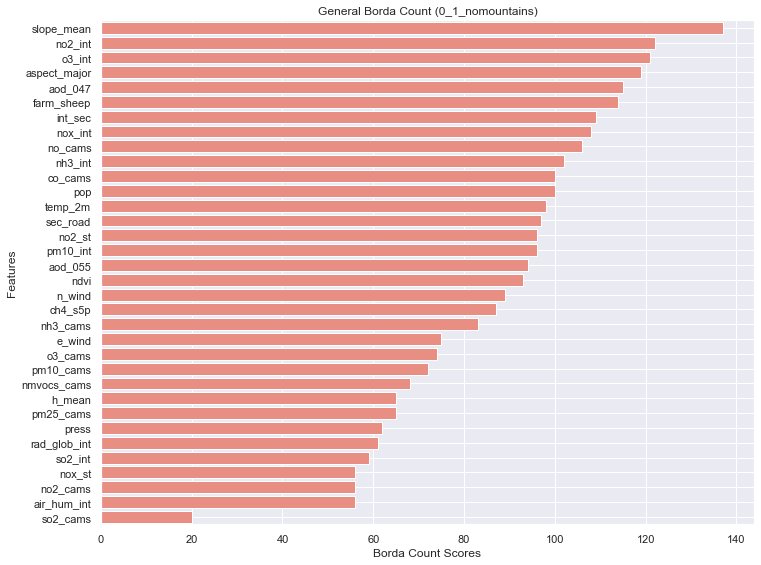

<Figure size 842.4x667.44 with 0 Axes>

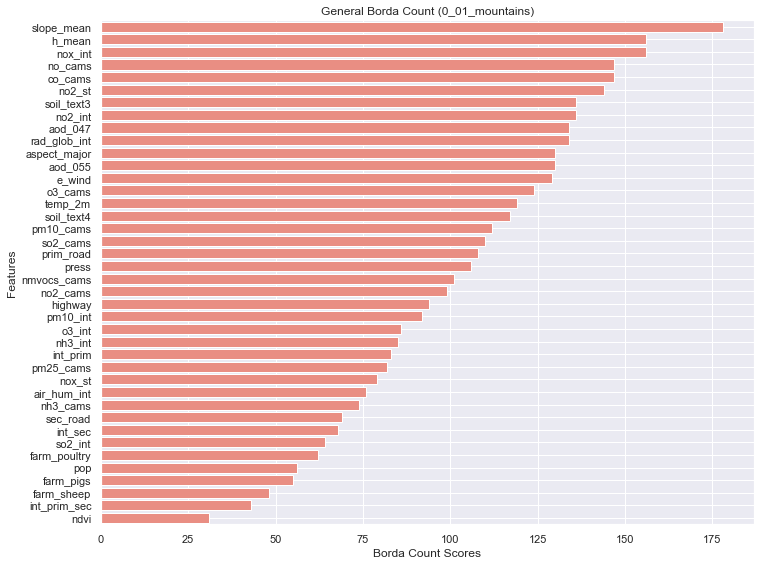

<Figure size 842.4x667.44 with 0 Axes>

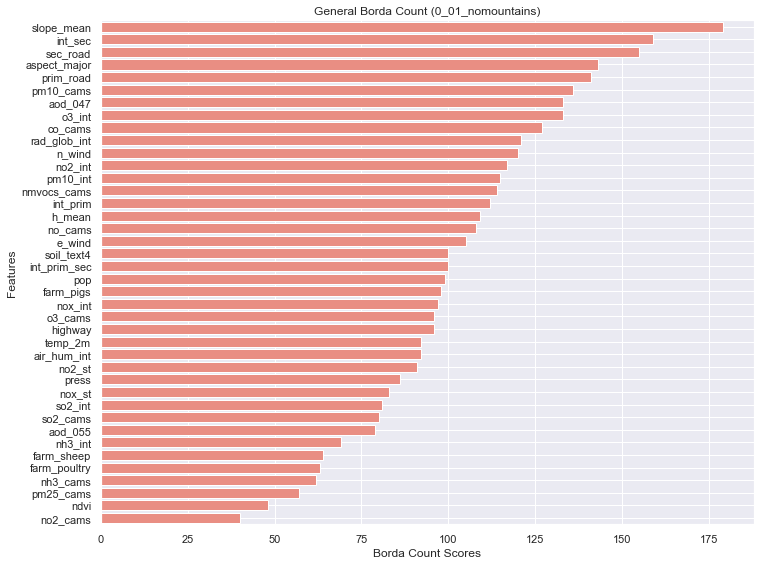

<Figure size 842.4x667.44 with 0 Axes>

In [4]:
from plotly.subplots import make_subplots
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go


for par in params:
    
    dataframes_results = dictionary_results[par]
    borda_res = pd.DataFrame()

    for index, grid in enumerate(geopackages):
        borda_res['Features'] = dataframes_results[grid]['Features']
        borda_res[grid] = dataframes_results[grid]['Borda Count Voting']
    borda_res['General Borda Count'] = m.borda_voting(borda_res)
    borda_res = borda_res.sort_values(by=['General Borda Count'], ascending = False)
    borda_res.to_csv('assets/fs_results/'+target_var+par+'_features_model.csv')

    sns.set()
    sns.set(rc={'figure.figsize':(11.7,9.27)})
    f = plt.figure()
    sns.barplot(
    y='Features', 
    x='General Borda Count',
    color='salmon', 
    data=borda_res
)

    
    plt.xticks(rotation=0)
    plt.ylabel("Features")
    plt.xlabel("Borda Count Scores")
    plt.title('General Borda Count ('+par+')')
    plt.gca().yaxis.grid(linestyle='-')
    #fig = f.get_figure()
    #fig.savefig('tests/'+grid[:-5]+'.png', bbox_inches='tight')
    plt.show()
    plt.clf()
    


    


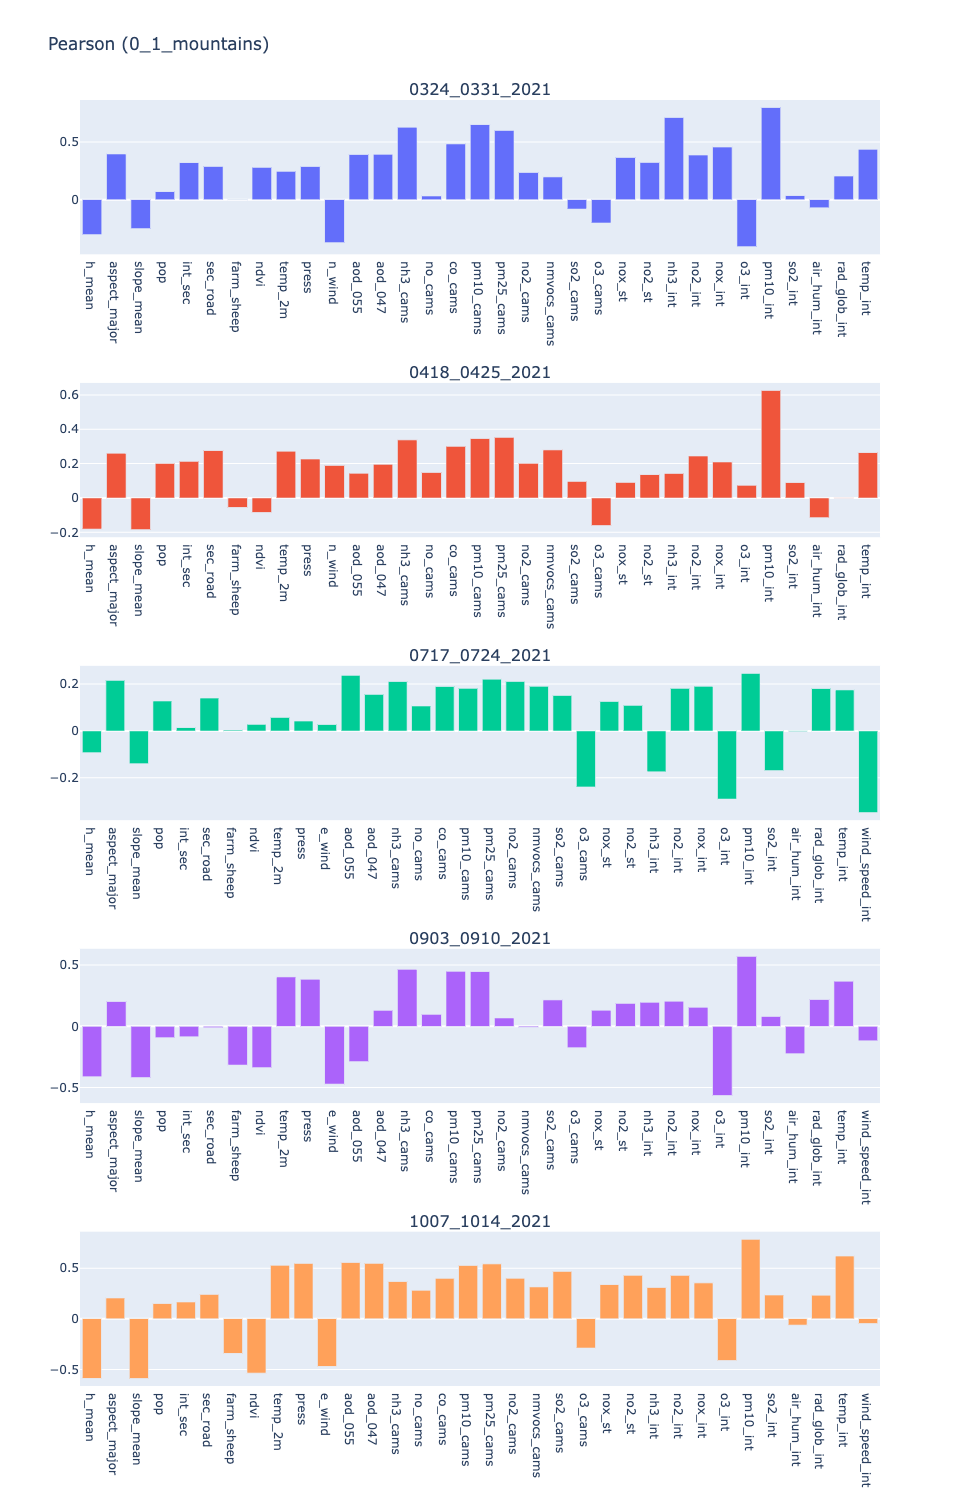

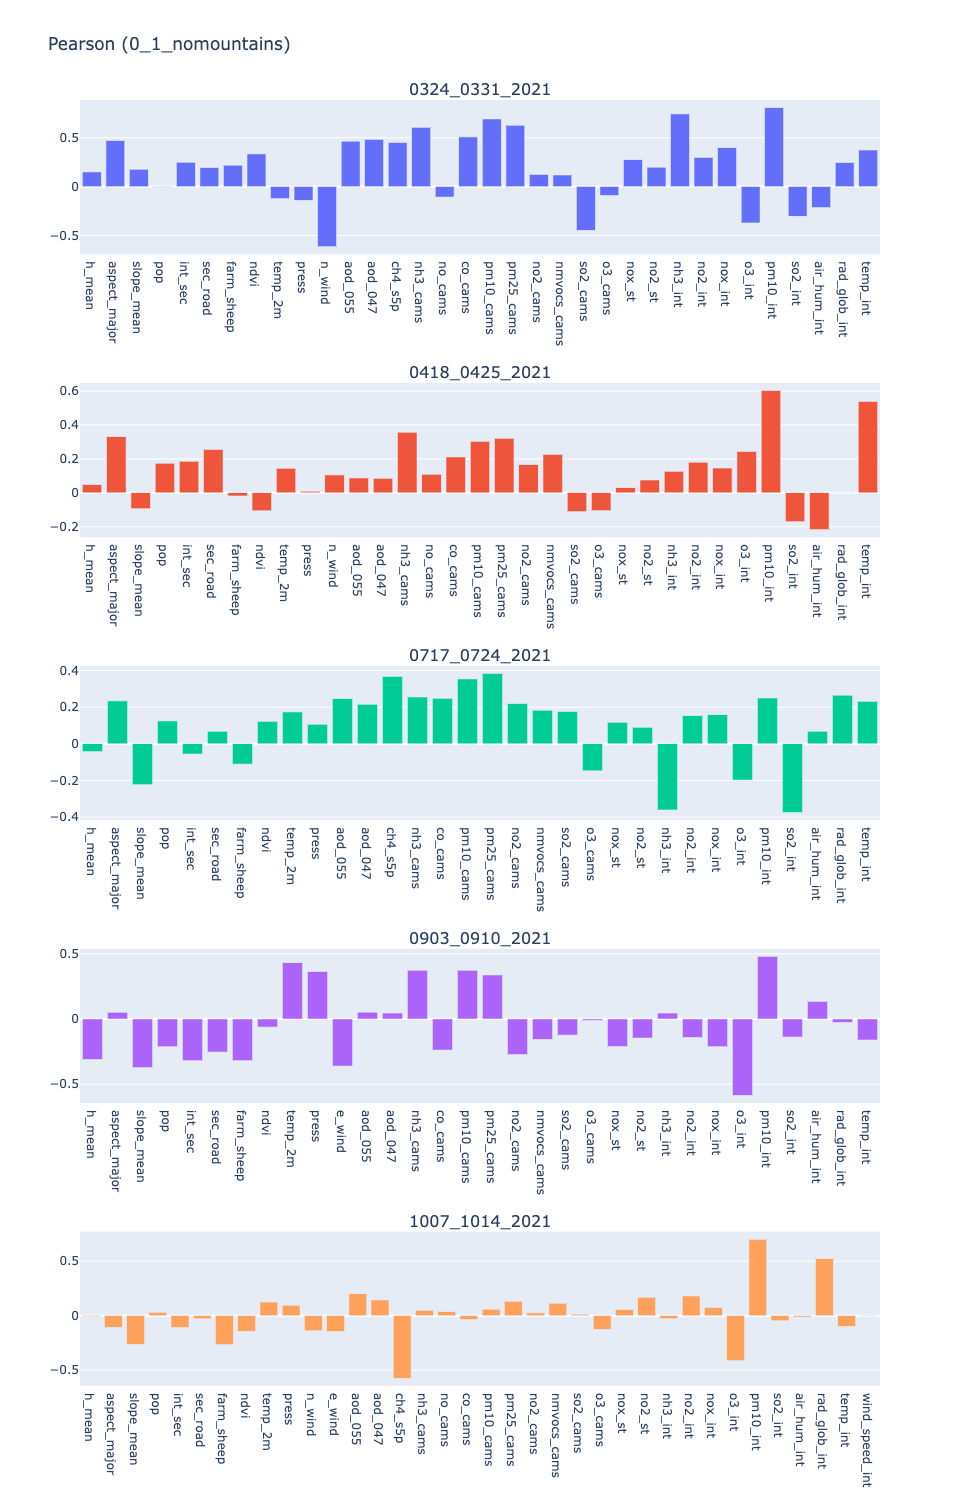

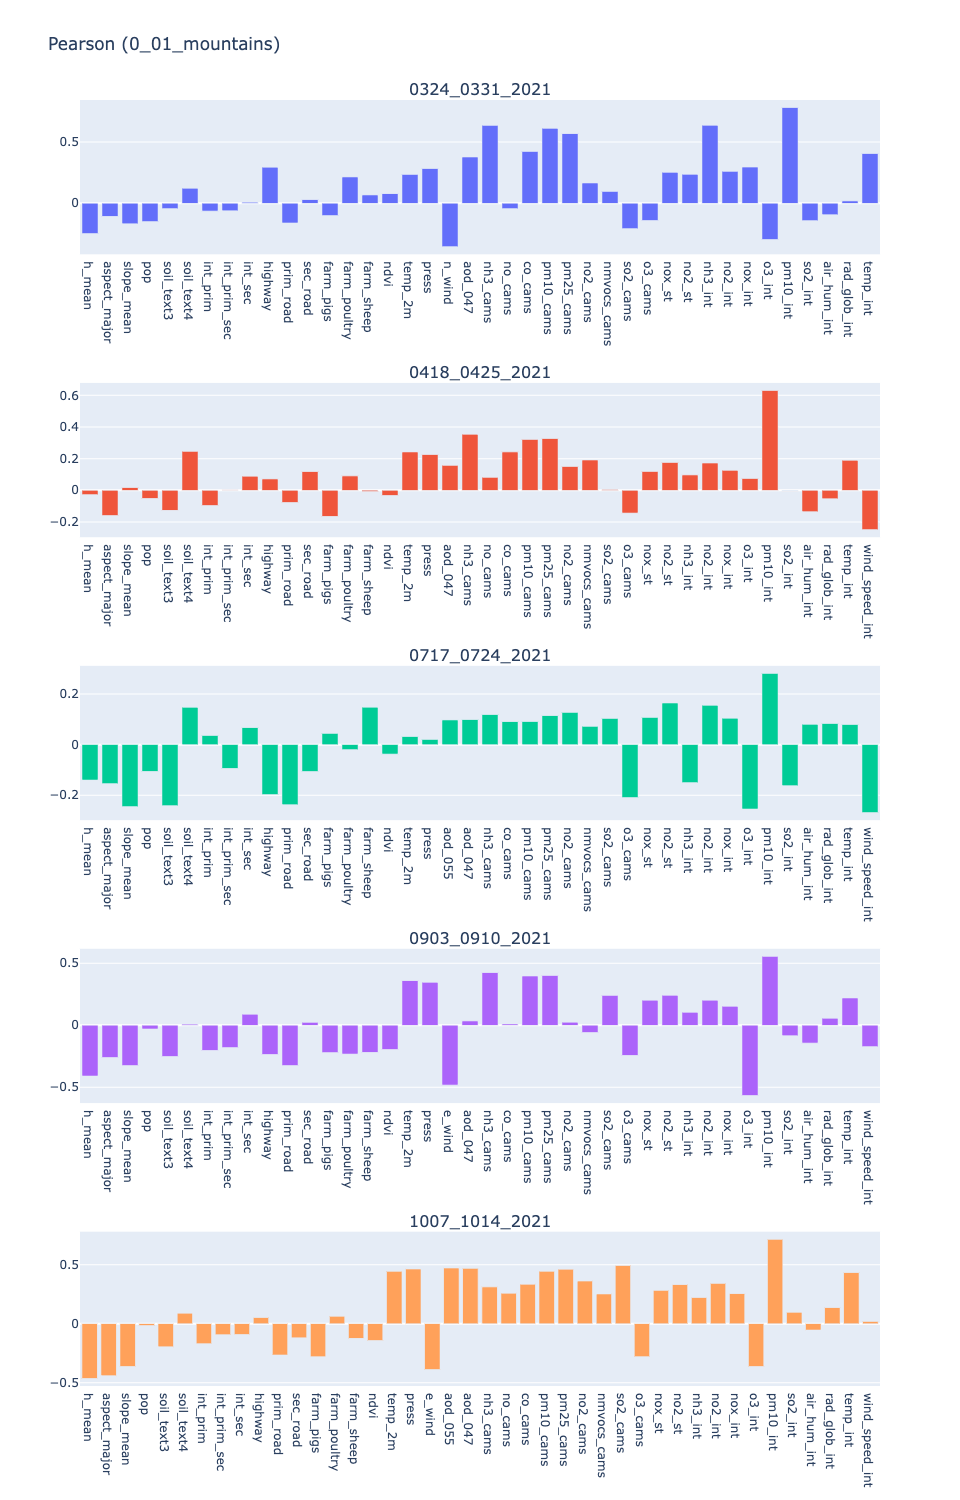

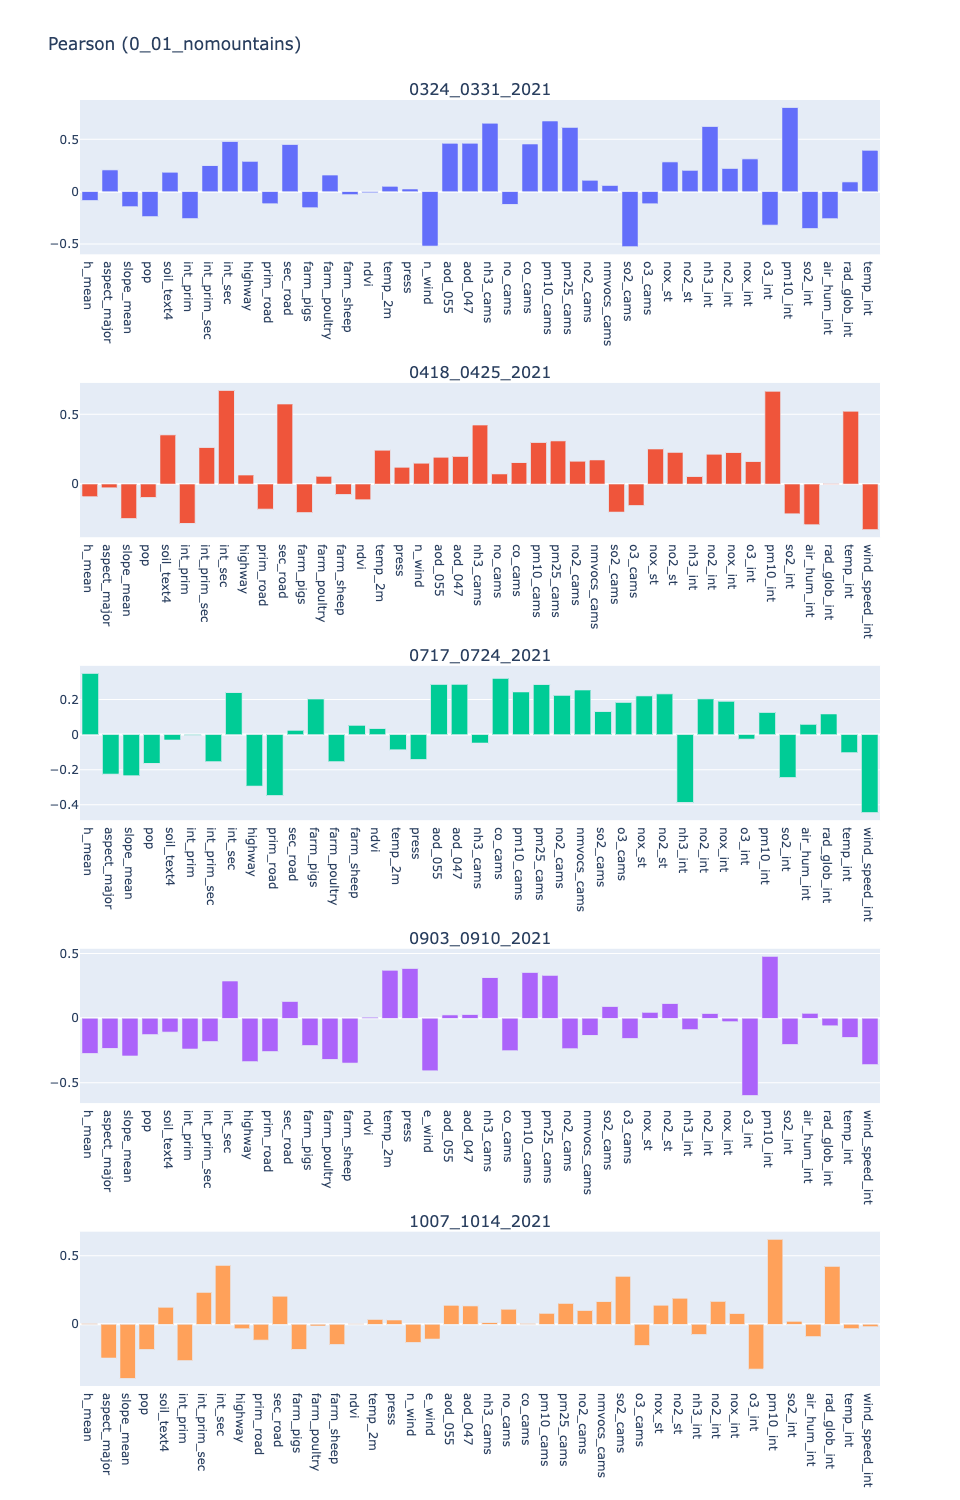

In [5]:
for par in params:
    dataframes_results = dictionary_results[par]
    fig = make_subplots(rows=5, cols=1, subplot_titles=geopackages)
    for index, grid in enumerate(geopackages):
        labels = dataframes_results[grid]['Features'].tolist()
        values = dataframes_results[grid]['Pearson'].tolist()
        fig.add_trace(go.Bar(x=labels, y=values), row=index+1, col=1)
        fig.update_yaxes(row=index+1, col=1)
        fig.update_xaxes(type="category", row=index+1, col=1)

    fig.update_layout(height=1500, width=1000 , title_text='Pearson (' +par+ ')')
    fig.update_layout(showlegend=False, autosize=True)
    fig.show()
